# 2025 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

In [40]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader,Dataset
import transformers
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from sentence_transformers import SentenceTransformer, InputExample, losses
import faiss

import colbert

from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert import Indexer, Searcher


from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [41]:
import os
os.chdir('Automated-Fact-checking-System')
print("Working space:", os.getcwd())


FileNotFoundError: [Errno 2] No such file or directory: 'Automated-Fact-checking-System'

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [49]:
class ClaimEvidenceDataset(Dataset):

    def __init__(self, claims, evidence, tokenizer, max_len=512, if_train=True):
        self.claim_texts = []
        self.evidence_texts = []
        self.tokenizer = tokenizer
        self.max_length = max_len
        self.if_train = if_train
        if if_train:
            self.labels = []

        self.label2id = {
            "SUPPORTS": 0,
            "REFUTES": 1,
            "NOT_ENOUGH_INFO": 2,
            "DISPUTED": 3
        }

        for claim_idx, claim_info in claims.items():
            self.claim_texts.append(claim_info['claim_text'])
            evidence_text = ""
            for evid in claim_info['evidences']:
                if evid in evidence:
                    evidence_text += evidence[evid] + " "
            self.evidence_texts.append(evidence_text.strip())
            if if_train:
                self.labels.append(self.label2id[claim_info['claim_label']])

            
    def __len__(self):
        return len(self.claim_texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.claim_texts[idx],
            self.evidence_texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        if self.if_train:
            return {
                'input_ids': encoded['input_ids'].squeeze(0),
                'attention_mask': encoded['attention_mask'].squeeze(0),
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)
            }
        else:
            return {
                'input_ids': encoded['input_ids'].squeeze(0),
                'attention_mask': encoded['attention_mask'].squeeze(0),
            }


In [ ]:
with open("data/train-claims.json", 'r') as f:
    train_claims = json.load(f)

with open("data/test-claims-unlabelled.json", 'r') as f:
    test_claims = json.load(f)

with open("data/evidence.json", 'r') as f:
    evidence = json.load(f)

evidence_ids = list(evidence.keys())
evidence_texts = list(evidence.values())

with open("data/dev-claims-baseline.json", "r") as f:
    train_data_baseline = json.load(f)

with open('data/evidence_colbert.tsv', 'w', encoding='utf-8') as f_out:
    for idx, text in enumerate(evidence.values()):
        text = text.replace("\t", " ")
        f_out.write(f"{idx}\t{text.strip()}\n")


# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
#This method has been deprecated, do not use it
#!!!*****only run once(I have run it in local), if you want to re-index, set overwrite=True*****!!!

#Colbert Indexing, Tokenization and embedding in evidence_colbert.txt
checkpoint = "colbert-ir/colbertv2.0"
index_name = "evidence_index"
doc_maxlen = 180

with Run().context(RunConfig(nranks=1, experiment="colab_run", root="./colbert")):
    config = ColBERTConfig(nbits=2, root="./colbert")
    indexer = Indexer(checkpoint=checkpoint, config=config)
    #indexer.index(name=index_name, collection="data/evidence_colbert.tsv",overwrite=True)
    indexer.index(name=index_name, collection="data/evidence_colbert.tsv")

In [ ]:
#!!!Only run once!!!
#Finetuning the intfloat/e5-base-v2 model base on our training data
train_pairs = []

for claim_info in train_claims.values():
    claim_text = claim_info["claim_text"]
    for evid_id in claim_info["evidences"]:
        if evid_id in evidence:
            evidence_text = evidence[evid_id]
            train_pairs.append((claim_text, evidence_text))

train_examples = [
    InputExample(texts=["query: " + claim, "passage: " + evidence]) for claim, evidence in train_pairs
]

e5_base_model = SentenceTransformer("intfloat/e5-base-v2") 

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.MultipleNegativesRankingLoss(e5_base_model)

e5_base_model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=5,
    warmup_steps=100,
    show_progress_bar=True,
    output_path="e5_finetuned_co2"
)

#model will be saved in the e5_finetuned_co2 folder in current working directory

In [43]:
#Load the fine-tuned model
E5_model = SentenceTransformer("e5_finetuned_co2")

# Create Indexing system for evidence texts(only run once)
'''
evidence_texts_with_prefix = ["passage: " + text for text in evidence_texts]

evidence_embeddings = E5_model.encode(evidence_texts_with_prefix, convert_to_tensor=False, show_progress_bar=True)

embedding_dim = evidence_embeddings[0].shape[0]
index = faiss.IndexFlatL2(embedding_dim)

index.add(np.array(evidence_embeddings))

faiss.write_index(index, "E5/e5_index.faiss")
'''

# Load the index
e5_index = faiss.read_index("E5/e5_index.faiss")

In [ ]:
#Roberta Model setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4).to(device)
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-large', num_labels=4).to(device)

epochs = 24

batch_size = 16

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scaler = torch.cuda.amp.GradScaler()#accelerate

train_steps = int((len(train_claims) * epochs)/batch_size)
num_steps = int(train_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

train_dataset = ClaimEvidenceDataset(train_claims, evidence, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

#valid_dataset = ClaimEvidenceDataset(test_claims, evidence, tokenizer, if_train = False)
#valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=True)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
#freeze last 3 layer
for param in model.parameters():
    param.requires_grad = False

for layer in model.roberta.encoder.layer[-3:]:
    for param in layer.parameters():
        param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True


In [25]:
def training(train_dataloader, model, optimizer, scheduler, scaler, device):
    model.train()
    correct_predictions = 0
    total_loss = 0
    num_batches = 0
    total_samples = 0

    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(ids, attention_mask=mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        num_batches += 1

    avg_epoch_loss = total_loss / num_batches
    accuracy = correct_predictions / total_samples

    return avg_epoch_loss, accuracy


def validating(val_dataloader, model, device):
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)

            outputs = model(ids, attention_mask=mask)
            logits = outputs.logits

            print(logits)

            preds = torch.argmax(logits, dim=1)
            all_predictions.extend(preds.cpu().tolist())

    return all_predictions
    


Epoch 1/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:26<00:00,  2.88it/s]


Train Loss: 1.4073
Train Accuracy: 0.2826
Epoch 2/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:26<00:00,  2.87it/s]


Train Loss: 1.1882
Train Accuracy: 0.4910
Epoch 3/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.83it/s]


Train Loss: 0.9855
Train Accuracy: 0.5961
Epoch 4/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:28<00:00,  2.75it/s]


Train Loss: 0.9503
Train Accuracy: 0.6140
Epoch 5/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:28<00:00,  2.70it/s]


Train Loss: 0.8795
Train Accuracy: 0.6588
Epoch 6/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:28<00:00,  2.68it/s]


Train Loss: 0.8179
Train Accuracy: 0.6808
Epoch 7/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.81it/s]


Train Loss: 0.7568
Train Accuracy: 0.6832
Epoch 8/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:26<00:00,  2.86it/s]


Train Loss: 0.7366
Train Accuracy: 0.6938
Epoch 9/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:26<00:00,  2.86it/s]


Train Loss: 0.6945
Train Accuracy: 0.7060
Epoch 10/24
----------


 49%|██████████████████████████████████████████████████████████████████████████▌                                                                            | 38/77 [00:13<00:14,  2.75it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.84it/s]


Train Loss: 0.6009
Train Accuracy: 0.7467
Epoch 11/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.81it/s]


Train Loss: 0.5268
Train Accuracy: 0.7883
Epoch 12/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.84it/s]


Train Loss: 0.4867
Train Accuracy: 0.7964
Epoch 13/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.77it/s]


Train Loss: 0.4278
Train Accuracy: 0.8339
Epoch 14/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.85it/s]


Train Loss: 0.3845
Train Accuracy: 0.8518
Epoch 15/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:26<00:00,  2.89it/s]


Train Loss: 0.3469
Train Accuracy: 0.8624
Epoch 16/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.83it/s]


Train Loss: 0.2948
Train Accuracy: 0.8901
Epoch 17/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:26<00:00,  2.86it/s]


Train Loss: 0.2517
Train Accuracy: 0.9194
Epoch 18/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:27<00:00,  2.82it/s]


Train Loss: 0.2248
Train Accuracy: 0.9259
Epoch 19/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:26<00:00,  2.87it/s]


Train Loss: 0.1872
Train Accuracy: 0.9381
Epoch 20/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:28<00:00,  2.74it/s]


Train Loss: 0.1831
Train Accuracy: 0.9430
Epoch 21/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:26<00:00,  2.87it/s]


Train Loss: 0.1548
Train Accuracy: 0.9528
Epoch 22/24
----------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:28<00:00,  2.71it/s]


Train Loss: 0.1575
Train Accuracy: 0.9495
Epoch 23/24
----------


100%|██████████████| 77/77 [00:27<00:00,  2.75it/s]


Train Loss: 0.1358
Train Accuracy: 0.9642
Epoch 24/24
----------


100%|██████████████| 77/77 [00:28<00:00,  2.71it/s]
/tmp/ipykernel_18665/3101453765.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epoch_list, train_losses_list, 'bo-', label="Training Loss", color='blue')


Train Loss: 0.1251
Train Accuracy: 0.9707


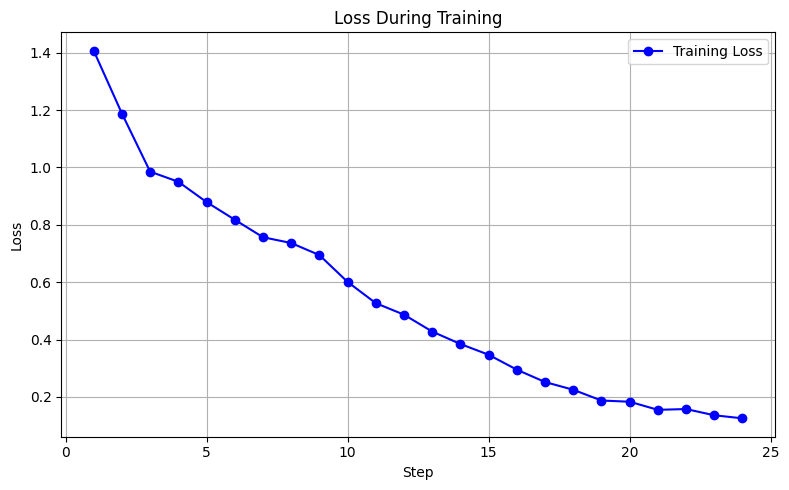

/tmp/ipykernel_18665/3101453765.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epoch_list, train_accuracies, 'bo-', label='Training Accuracy', color='green')


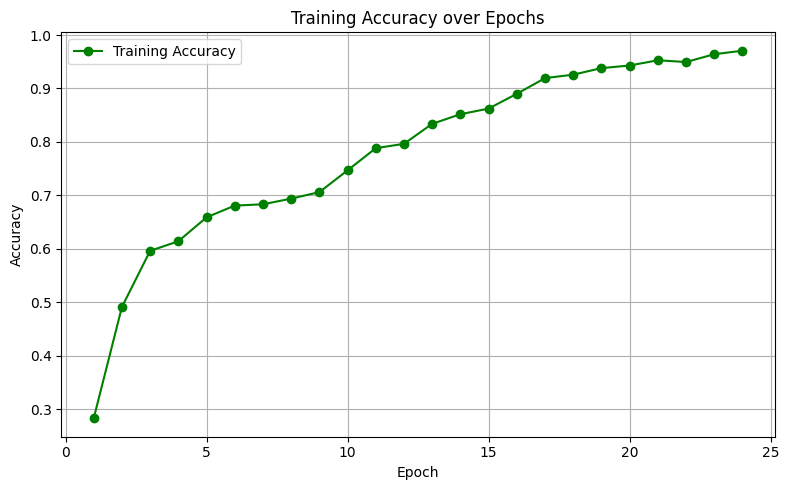

In [26]:
train_losses_list = []
train_accuracies = []

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    train_loss, accuracy = training(train_dataloader, model, optimizer, scheduler, scaler, device)

    print(f'Train Loss: {train_loss:.4f}')
    print(f'Train Accuracy: {accuracy:.4f}')
    train_losses_list.append(train_loss)
    train_accuracies.append(accuracy)

epoch_list = range(1, len(train_accuracies) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epoch_list, train_losses_list, 'bo-', label="Training Loss", color='blue')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss During Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epoch_list, train_accuracies, 'bo-', label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
#Colbert Retrieval
checkpoint = "colbert-ir/colbertv2.0"
index_name = "evidence_index"
doc_maxlen = 180
searcher = Searcher(index=index_name, checkpoint=checkpoint, index_root="colbert/colab_run/indexes")

def retrieve(claim, k=10, threshould=2.0):
    with torch.no_grad():
        doc_ids, rank, scores = searcher.search(claim, k=k)

        print("scores: " , scores)
        Top_score = scores[0]
        print(doc_ids)

        filtered = [
            (doc_id, score)
            for doc_id, score in zip(doc_ids, scores)
            if score >= Top_score - threshould
        ]

        if not filtered:
            return ""
        
        retrieved_text = " ".join([
            searcher.collection[doc_id].replace("\n", " ").strip()
            for doc_id, score in filtered
        ])
        return retrieved_text

claim = "Weather Channel co-founder John Coleman provided evidence that convincingly refutes the concept of anthropogenic global warming."
retrieved_evidence = retrieve(claim)

print(retrieved_evidence)

[May 11, 00:51:05] #> Loading collection...
0M 1M 
[May 11, 00:51:10] #> Loading codec...
[May 11, 00:51:10] #> Loading IVF...
[May 11, 00:51:10] #> Loading doclens...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 2002.17it/s]

[May 11, 00:51:10] #> Loading codes and residuals...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 108.17it/s]



#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Weather Channel co-founder John Coleman provided evidence that convincingly refutes the concept of anthropogenic global warming., 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  4633,  3149,  2522,  1011,  3910,  2198, 11608,  3024,
         3350,  2008, 13359,  2135, 25416, 10421,  2015,  1996,  4145,  1997,
        14405,  8093,  7361, 24278,  3795, 12959,  1012,   102,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')

scores:  [19.296875, 18.28125, 18.015625, 17.890625, 17.671875, 17.59375, 17.421875, 17.375, 17.359375, 17.296875]
[796796, 268745, 1137830, 617164, 693451, 230669, 246753, 844208, 210921, 1146282]
Climate change has also been called the "greatest scam in history" by John Coleman, who co-founded

In [72]:
#E5 retrieval
def E5_retrieve(claim, E5_model, index, k=3):

    result = {}

    for claim_id, info in claim.items():
        claim_text = info["claim_text"]
        claim_emb = E5_model.encode(f"query: {claim_text}")
        D, I = index.search(np.array([claim_emb]), k=k)

        top_evid_ids = [evidence_ids[i] for i in I[0]]
        
        result[claim_id] = {
            "claim_text": claim_text,
            "evidences": top_evid_ids
        }

    return result

claim = {"claim-2967": {"claim_text": "The minute increase of anthropogenic CO2\u00a0in the atmosphere (0.008%) was not the cause of the warming\u2014it was a continuation of natural cycles that occurred over the past 500 years."}}
claim_e5 = E5_retrieve(claim, E5_model,e5_index, k=3)
print(claim_e5)


{'claim-2967': {'claim_text': 'The minute increase of anthropogenic CO2\xa0in the atmosphere (0.008%) was not the cause of the warming—it was a continuation of natural cycles that occurred over the past 500 years.', 'evidences': ['evidence-510852', 'evidence-823476', 'evidence-251138']}}


In [73]:
valid_dataset = ClaimEvidenceDataset(claim_e5, evidence, tokenizer, if_train = False)
valid_dataloader = DataLoader(valid_dataset, batch_size)

id2label = {
    0: "SUPPORTS",
    1: "REFUTES",
    2: "NOT_ENOUGH_INFO",
    3: "DISPUTED"
}

predictions = validating(valid_dataloader, model, device)
label_names = [id2label[p] for p in predictions]
print(label_names)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]

tensor([[ 1.2065,  1.8308, -4.4449,  1.2114]], device='cuda:0')
['REFUTES']


## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*